# Εφαρμογή 5

In [1]:
import sympy as sym
from sympy import Matrix
from mitroiki_functs import K_without_axial
from mitroiki_functs import P_point_load_at_distance_a, P_uniformly_distributed_load
from mitroiki_functs import round_expr

# from common.statics.mitroiki_functs import K_without_axial
# from common.statics.mitroiki_functs import P_point_load_at_distance_a, P_uniformly_distributed_load
# from common.statics.mitroiki_functs import round_expr

import openseespy.opensees as ops
import opsvis as opsv
import matplotlib.pyplot as plt

# from IPython.display import Image

Να υπολογιστούν οι αντιδράσεις στήριξης, οι παραμορφώσεις και τα διαγράμματα των εντατικών μεγεθών για τον φορέα του σχήματος.

Να αγνοηθούν οι αξονικοί βαθμοί ελευθερίας

<img src="https://raw.githubusercontent.com/panagop/ihu_courses/main/images/mitroa/example5/ekfonisi.png" width="650">

In [4]:
E = 20_000.
I = 1.
L1 = 3.0
L2 = 4.0
L3 = 4.0

q1_load = 10.
q2_load = 40.

## Αντιστοίχιση τοπικών - καθολικών βαθμών ελευθερίας

| Καθολ. Συστ. | (1) | (2) | (3) | (4) | (5) | (6) | (7) | (8) | (9) |
|--------------|-----|-----|-----|-----|-----|-----|-----|-----|-----|
| 1-2          | -1  |     |  2  | -3  |  4  |     |     |     |     |
| 2-3          |     | 1   |     |     |  2  |  3  | 4   |     |     |
| 2-4          |     |     |     |     |     |  1  | 2   | 3   | 4   |

<img src="https://raw.githubusercontent.com/panagop/ihu_courses/main/images/mitroa/example5/dof_global_local.png" width="650">

## Μητρώα στιβαρότητας στοιχείων
Τα στοιχεία 2 (2-3) και 3 (3-4) έχουν όμοια μητρώα στιβαρότητας (ίδιες διαστάσεις, διατομές, υλικά)

In [5]:
K1 = K_without_axial(E=E, I=I, L=L1)
round_expr(K1, 1)

Matrix([
[ 8888.9,  13333.3,  -8888.9,  13333.3],
[13333.3,  26666.7, -13333.3,  13333.3],
[-8888.9, -13333.3,   8888.9, -13333.3],
[13333.3,  13333.3, -13333.3,  26666.7]])

In [6]:
K2 = K3 = K_without_axial(E=E, I=1.5*I, L=L2)
round_expr(K2, 1)

Matrix([
[ 5625.0,  11250.0,  -5625.0,  11250.0],
[11250.0,  30000.0, -11250.0,  15000.0],
[-5625.0, -11250.0,   5625.0, -11250.0],
[11250.0,  15000.0, -11250.0,  30000.0]])

## Μητρώο στιβαρότητας φορέα
Είναι διαστάσεων 9x9 και δημιουργείται από το συνδυασμό των επιμέρους μητρώων, βάσει της αντιστοίχισης των βαθμών ελευθερίας στο καθολικό σύστημα συντεταγμένων

Δημιουργείται ένα μηδενικό μητρώο 9x9 και σταδιακά προστίθενται οι τιμές στις κατάλληλες θέσεις

Προσοχή στα πρόσημα! Για παράδειγμα: 

- Το Κ11 έχει (-) x (-) = (+)
- To K13 έχει (-) x (+) = (-)
- To K14 έχει (-) x (-) = (+)
- κοκ

| Καθολ. Συστ. | (1) | (2) | (3) | (4) | (5) | (6) | (7) | (8) | (9) |
|--------------|-----|-----|-----|-----|-----|-----|-----|-----|-----|
| 1-2          | -1  |     |  2  | -3  |  4  |     |     |     |     |
| 2-3          |     | 1   |     |     |  2  |  3  | 4   |     |     |
| 2-4          |     |     |     |     |     |  1  | 2   | 3   | 4   |

In [7]:
K1_temp = sym.zeros(9,9)

K1_temp[0, 0] += +K1[0, 0]       # (-) x (-) = (+)
K1_temp[2, 0] += -K1[1, 0]       # (+) x (-) = (-)
K1_temp[3, 0] += +K1[2, 0]       # (-) x (-) = (+)
K1_temp[4, 0] += -K1[3, 0]       # (+) x (-) = (-)

K1_temp[0, 2] += -K1[0, 1]       # (-) x (+) = (-)
K1_temp[2, 2] += +K1[1, 1]       # (+) x (+) = (+)
K1_temp[3, 2] += -K1[2, 1]       # (-) x (+) = (-)
K1_temp[4, 2] += +K1[3, 1]       # (+) x (+) = (+)

K1_temp[0, 3] += +K1[0, 2]       # (-) x (-) = (+)
K1_temp[2, 3] += -K1[1, 2]       # (+) x (-) = (-)
K1_temp[3, 3] += +K1[2, 2]       # (-) x (-) = (+)
K1_temp[4, 3] += -K1[3, 2]       # (+) x (-) = (-)

K1_temp[0, 4] += -K1[0, 3]       # (-) x (+) = (-)
K1_temp[2, 4] += +K1[1, 3]       # (+) x (+) = (+)
K1_temp[3, 4] += -K1[2, 3]       # (-) x (+) = (-)
K1_temp[4, 4] += +K1[3, 3]       # (+) x (+) = (+)

round_expr(K1_temp, 1)

Matrix([
[  8888.9, 0, -13333.3, -8888.9, -13333.3, 0, 0, 0, 0],
[       0, 0,        0,       0,        0, 0, 0, 0, 0],
[-13333.3, 0,  26666.7, 13333.3,  13333.3, 0, 0, 0, 0],
[ -8888.9, 0,  13333.3,  8888.9,  13333.3, 0, 0, 0, 0],
[-13333.3, 0,  13333.3, 13333.3,  26666.7, 0, 0, 0, 0],
[       0, 0,        0,       0,        0, 0, 0, 0, 0],
[       0, 0,        0,       0,        0, 0, 0, 0, 0],
[       0, 0,        0,       0,        0, 0, 0, 0, 0],
[       0, 0,        0,       0,        0, 0, 0, 0, 0]])

In [8]:
K2_temp = sym.zeros(9,9)

K2_temp[1, 1] += K2[0, 0]
K2_temp[4:7, 1] += K2[1:4, 0]
K2_temp[1, 4:7] += K2[0, 1:4]
K2_temp[4:7, 4:7] += K2[1:4, 1:4]

round_expr(K2_temp, 1)

Matrix([
[0,       0, 0, 0,        0,        0,        0, 0, 0],
[0,  5625.0, 0, 0,  11250.0,  -5625.0,  11250.0, 0, 0],
[0,       0, 0, 0,        0,        0,        0, 0, 0],
[0,       0, 0, 0,        0,        0,        0, 0, 0],
[0, 11250.0, 0, 0,  30000.0, -11250.0,  15000.0, 0, 0],
[0, -5625.0, 0, 0, -11250.0,   5625.0, -11250.0, 0, 0],
[0, 11250.0, 0, 0,  15000.0, -11250.0,  30000.0, 0, 0],
[0,       0, 0, 0,        0,        0,        0, 0, 0],
[0,       0, 0, 0,        0,        0,        0, 0, 0]])

In [9]:
K3_temp = sym.zeros(9,9)

K3_temp[5:, 5:] += K3

round_expr(K3_temp, 1)

Matrix([
[0, 0, 0, 0, 0,       0,        0,        0,        0],
[0, 0, 0, 0, 0,       0,        0,        0,        0],
[0, 0, 0, 0, 0,       0,        0,        0,        0],
[0, 0, 0, 0, 0,       0,        0,        0,        0],
[0, 0, 0, 0, 0,       0,        0,        0,        0],
[0, 0, 0, 0, 0,  5625.0,  11250.0,  -5625.0,  11250.0],
[0, 0, 0, 0, 0, 11250.0,  30000.0, -11250.0,  15000.0],
[0, 0, 0, 0, 0, -5625.0, -11250.0,   5625.0, -11250.0],
[0, 0, 0, 0, 0, 11250.0,  15000.0, -11250.0,  30000.0]])

Οπότε το συνολικό μητρώο του φορέα είναι το $Κ$

In [10]:
K = K1_temp + K2_temp + K3_temp
round_expr(K, 1)

Matrix([
[  8888.9,       0, -13333.3, -8888.9, -13333.3,        0,        0,        0,        0],
[       0,  5625.0,        0,       0,  11250.0,  -5625.0,  11250.0,        0,        0],
[-13333.3,       0,  26666.7, 13333.3,  13333.3,        0,        0,        0,        0],
[ -8888.9,       0,  13333.3,  8888.9,  13333.3,        0,        0,        0,        0],
[-13333.3, 11250.0,  13333.3, 13333.3,  56666.7, -11250.0,  15000.0,        0,        0],
[       0, -5625.0,        0,       0, -11250.0,  11250.0,        0,  -5625.0,  11250.0],
[       0, 11250.0,        0,       0,  15000.0,        0,  60000.0, -11250.0,  15000.0],
[       0,       0,        0,       0,        0,  -5625.0, -11250.0,   5625.0, -11250.0],
[       0,       0,        0,       0,        0,  11250.0,  15000.0, -11250.0,  30000.0]])

## Μητρώο εξωτερικής φόρτισης

### Στοιχείο 1
Το στοιχείο 1 παραλαμβάνει ομοιόμορφα κατανεμημένο φορτίο $q_1=10\text{kN/m}$

In [11]:
P1 = P_uniformly_distributed_load(q=q1_load, L=L1)
round_expr(P1, 2)

Matrix([
[-15.0],
[ -7.5],
[-15.0],
[  7.5]])

### Στοιχείο 3
Το στοιχείο 3 παραλαμβάνει ομοιόμορφα κατανεμημένο φορτίο $q_2=40\text{kN/m}$

In [12]:
P3 = P_uniformly_distributed_load(q=q2_load, L=L3)
round_expr(P3, 2)

Matrix([
[ -80.0],
[-53.33],
[ -80.0],
[ 53.33]])

### Συνολικό μητρώο εξωτερικής φόρτισης

Για να προκύψει το συνολικό μητρώο $P$, συνδυάζονται τα επιμέρους μητρώα των δύο στοιχείων, λαμβάνοντας υπόψη τη συσχέτιση των τοπικών με τους καθολικούς βαθμούς ελευθερίας

| Καθολ. Συστ. | (1) | (2) | (3) | (4) | (5) | (6) | (7) | (8) | (9) |
|--------------|-----|-----|-----|-----|-----|-----|-----|-----|-----|
| 1-2          | -1  |     |  2  | -3  |  4  |     |     |     |     |
| 2-3          |     | 1   |     |     |  2  |  3  | 4   |     |     |
| 2-4          |     |     |     |     |     |  1  | 2   | 3   | 4   |

Δημιουργείται ένα μητρώο 9x1 και στη συνέχεια προστίθενται οι τιμές στις κατάλληλες θέσεις

Προσοχή στα πρόσημα στη μεταφορά των δυνάμεων του στοιχείου 1

In [13]:
P1_temp = sym.zeros(9,1)
P1_temp[0, 0] += -P1[0]
P1_temp[2, 0] += P1[1]
P1_temp[3, 0] += -P1[2]
P1_temp[4, 0] += P1[3]
P1_temp

Matrix([
[15.0],
[   0],
[-7.5],
[15.0],
[ 7.5],
[   0],
[   0],
[   0],
[   0]])

In [14]:
P3_temp = sym.zeros(9,1)
P3_temp[5:,0] += P3
round_expr(P3_temp, 2)

Matrix([
[     0],
[     0],
[     0],
[     0],
[     0],
[ -80.0],
[-53.33],
[ -80.0],
[ 53.33]])

In [15]:
P = P1_temp + P3_temp
round_expr(P, 2)

Matrix([
[  15.0],
[     0],
[  -7.5],
[  15.0],
[   7.5],
[ -80.0],
[-53.33],
[ -80.0],
[ 53.33]])

## Δεσμευμένοι και ελεύθεροι βαθμοί ελευθερίας

Οι δεσμευμένοι βαθμοί ελευθερίας στο καθολικό σύστημα είναι οι <span style="color:red">(1)</span>, <span style="color:red">(2)</span>, <span style="color:red">(3)</span>, <span style="color:red">(4)</span>, <span style="color:red">(6)</span>, <span style="color:red">(8)</span> και <span style="color:red">(9)</span> λόγω της κύλισης στον κόμβο 3 και των πακτώσεων στους κόμβους 1 και 4.

Αντίθετα, ελεύθεροι είναι οι βαθμοί ελευθερίας <span style="color:blue">(5)</span> και <span style="color:blue">(7)</span>

<img src="https://raw.githubusercontent.com/panagop/ihu_courses/main/images/mitroa/example5/dof_global_local.png" width="650">

## Διαχωρισμός μητρώων

<img src="https://raw.githubusercontent.com/panagop/ihu_courses/main/images/mitroa/example5/Kuu_vs_Kru.png" width="800">

| Καθολ. Συστ. | <span style="color:red">(1)</span> | <span style="color:red">(2)</span> | <span style="color:red">(3)</span> | <span style="color:red">(4)</span> | <span style="color:blue">(5)</span> | <span style="color:red">(6)</span> | <span style="color:blue">(7)</span> | <span style="color:red">(8)</span> | <span style="color:red">(9)</span> |
|--------------|-----|-----|-----|-----|-----|-----|-----|-----|-----|
| 1-2          | -1  |     |  2  | -3  |  4  |     |     |     |     |
| 2-3          |     | 1   |     |     |  2  |  3  | 4   |     |     |
| 3-4          |     |     |     |     |     |  1  | 2   | 3   | 4   |




Ομοίως και για τα μητρώα εξωτερικής φόρτισης, παραμορφώσεων και αντιδράσεων

<img src="https://raw.githubusercontent.com/panagop/ihu_courses/main/images/mitroa/example5/PUR.png" width="750">

### Υπομητρώα στιβαρότητας

In [16]:
K_UU = K[[4,6], [4,6]]
round_expr(K_UU, 1)

Matrix([
[56666.7, 15000.0],
[15000.0, 60000.0]])

In [17]:
K_RU = K[[0, 1, 2, 3, 5, 7, 8], [4, 6]]
round_expr(K_RU, 1)

Matrix([
[-13333.3,        0],
[ 11250.0,  11250.0],
[ 13333.3,        0],
[ 13333.3,        0],
[-11250.0,        0],
[       0, -11250.0],
[       0,  15000.0]])

### Υπομητρώα εξωτερικής φόρτισης

In [18]:
P_U = P[[4,6], 0]
round_expr(P_U, 2)

Matrix([
[   7.5],
[-53.33]])

In [19]:
P_R = P[[0, 1, 2, 3, 5, 7, 8], 0]
round_expr(P_R, 2)

Matrix([
[ 15.0],
[    0],
[ -7.5],
[ 15.0],
[-80.0],
[-80.0],
[53.33]])

## Υπολογισμός παραμορφώσεων

Είναι $K_{UU}\cdot U_U = P_U + R_U$, με $R_U=0$

οπότε $K_{UU}\cdot U_U = P_U$

και τελικά $U_U = K_{UU}^{-1}\cdot P_U$

In [20]:
U_U = K_UU.inv() * P_U
round_expr(U_U, 5)

Matrix([
[ 0.00039],
[-0.00099]])

## Υπολογισμός αντιδράσεων στήριξης

Είναι $K_{RU}\cdot U_U = P_R + R_R$

οπότε $R_R = K_{RU}\cdot U_U - P_R$

In [21]:
R_R = K_RU*U_U - P_R
round_expr(R_R, 3)

Matrix([
[-20.249],
[ -6.678],
[ 12.749],
[ -9.751],
[ 75.571],
[ 91.107],
[-68.143]])

## Επίλυση/έλεγχος με το OpenSees

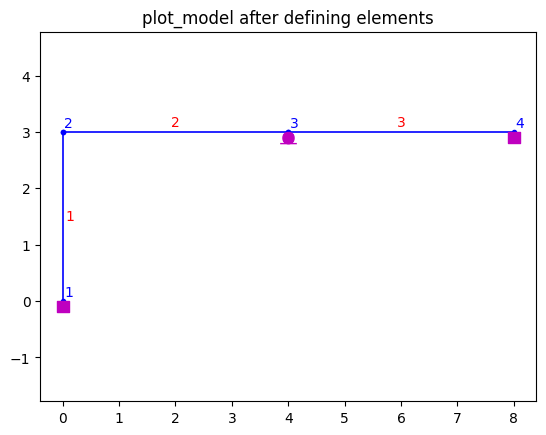

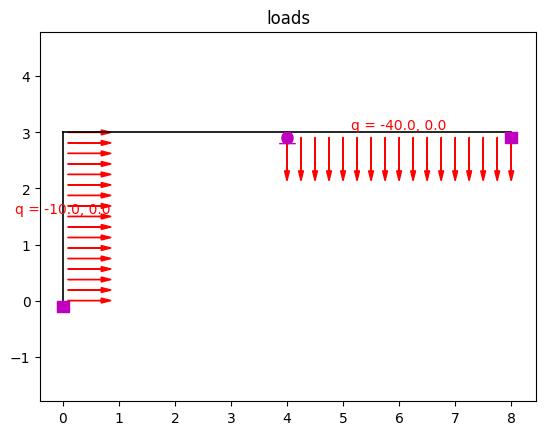

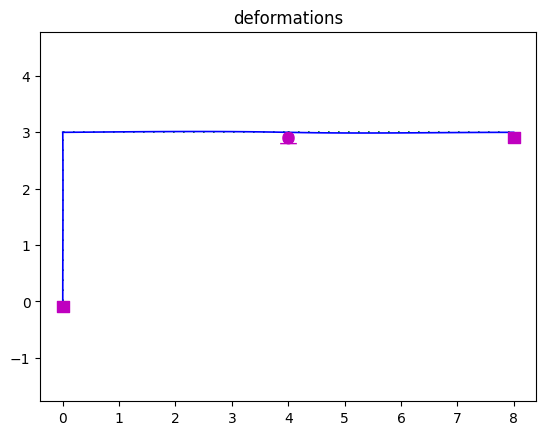

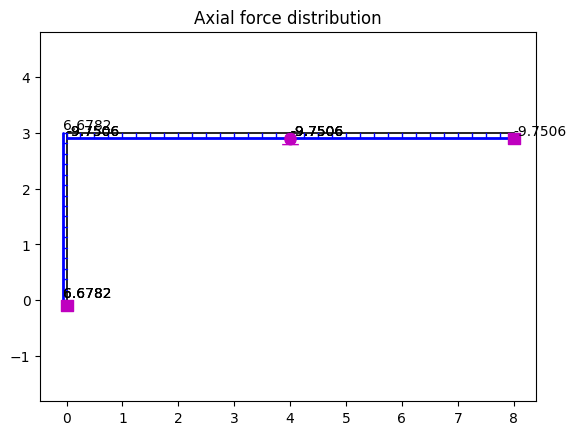

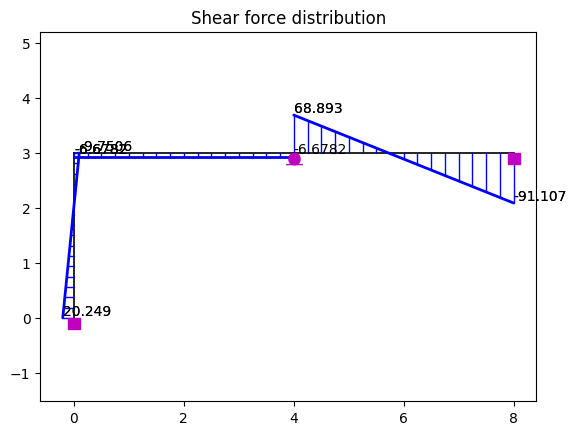

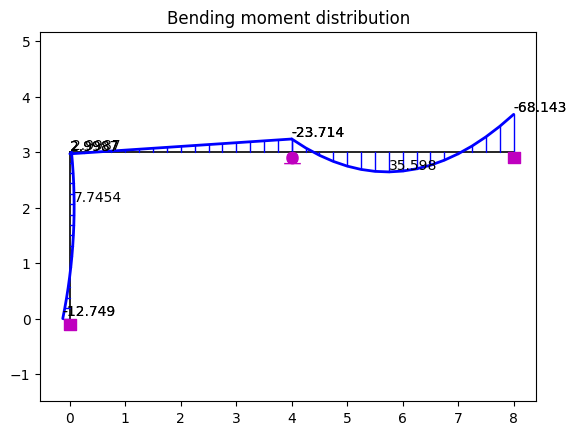

In [22]:
ops.wipe()
ops.model('basic', '-ndm', 2, '-ndf', 3)

A = 1000.
I = 1.
E = 10_000.

ops.node(1, 0., 0.)
ops.node(2, 0., L1)
ops.node(3, L2, L1)
ops.node(4, 2*L2, L1)

ops.fix(1, 1, 1, 1)
ops.fix(3, 0, 1, 0)
ops.fix(4, 1, 1, 1)

# opsv.plot_model()
# plt.title('plot_model before defining elements')

ops.geomTransf('Linear', 1)

# elements
ops.element('elasticBeamColumn', 1, 1, 2, 1000*A, E, I, 1)
ops.element('elasticBeamColumn', 2, 2, 3, 1000*A, E, 1.5*I, 1)
ops.element('elasticBeamColumn', 3, 3, 4, 1000*A, E, 1.5*I, 1)


# loads
ops.timeSeries('Constant', 1)
ops.pattern('Plain', 1, 1)

ops.eleLoad('-ele', 1, '-type', '-beamUniform', -q1_load)
ops.eleLoad('-ele', 3, '-type', '-beamUniform', -q2_load)



# analysis
ops.constraints('Transformation')
ops.numberer('RCM')
ops.system('BandGeneral')
ops.test('NormDispIncr', 1.0e-6, 6, 2)
ops.algorithm('Linear')
ops.integrator('LoadControl', 1)
ops.analysis('Static')
ops.analyze(1)

# results
# ops.printModel()
opsv.plot_model()
plt.title('plot_model after defining elements')

opsv.plot_loads_2d()
plt.title('loads')

sfac = 10.
opsv.plot_defo(sfac)
plt.title('deformations')

sfacN, sfacV, sfacM = 1.e-2, 1.e-2, 1.e-2
opsv.section_force_diagram_2d('N', sfacN)
plt.title('Axial force distribution')

opsv.section_force_diagram_2d('T', sfacV)
plt.title('Shear force distribution')

opsv.section_force_diagram_2d('M', sfacM)
plt.title('Bending moment distribution')


plt.show()

In [23]:
# U1, U2, U3, U4, U5, U6, U7, U8, U9 = sym.symbols('U1 U2 U3 U4 U5 U6 U7 U8 U9')
# P1, P2, P3, P4, P5, P6, P7, P8, P9 = sym.symbols('P1 P2 P3 P4 P5 P6 P7 P8 P9')
# R1, R2, R3, R4, R5, R6, R7, R8, R9 = sym.symbols('R1 R2 R3 R4 R5 R6 R7 R8 R9')

In [24]:
# U = Matrix([[U1], [U2], [U3], [U4], [U5], [U6], [U7], [U8], [U9]])
# U

In [25]:
# U.subs(U1, 0).subs(U2, 0).subs(U3, 0).subs(U4, 0).subs(U6, 0).subs(U8, 0).subs(U9, 0)

In [26]:
# P = Matrix([[P1], [P2], [P3], [P4], [P5], [P6], [P7]])
# P

In [27]:
# R = Matrix([[R1], [R2], [R3], [R4], [R5], [R6], [R7], [R8], [R9]])
# R

In [28]:
# R.subs(R5, 0).subs(R7, 0)